In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sajee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\sajee\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=3)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=3)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#applying model to test set, for challenge 0.
X_test_tfidf_csr = X_test_tfidf.tocsr()


#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: Emma was obliged to ask what they had told her , though fearful of its producing Mr . Elton .
Tf_idf vector: {'producing': 0.49800716119896493, 'ask': 0.37820399303630864, 'fearful': 0.46485208308634507, 'obliged': 0.3530361160312456, 'elton': 0.24540901423669018, 'told': 0.3817132197883509, 'mr': 0.18011343466017826, 'emma': 0.17279245614001376}


In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#fitting lsa to test set, for this particular challenge.
X_test_lsa = lsa.fit_transform(X_test_tfidf)



variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 48.7272597198354
Component 0:
" Oh !            0.999763
" Oh !            0.999763
" Oh !            0.999763
" Oh no , no !    0.999763
" Oh !            0.999763
" Oh !"           0.999763
" Oh !            0.999763
" Oh !            0.999763
" Oh !            0.999763
" Oh !            0.999763
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                  0.650948
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."                                                                                  0.583433
" In one respect , perhaps , Mr . Elton ' s manners are superior to Mr . Knightley ' s or Mr . Westo

The scores for the majority of the documents in each component are on the higher side, suggesting that the documents in each component are similar to each other and relevant to the topic.  

For example, component 0 contains sentences with "Oh!".  Component 1 seems to be primarily focused on a couple of the main characters.  Component 2 contains sentences with the word "Ah!".  Component 3 contains sentences abouut the character Mr. Knightley.  Component 4 is about the characters Miss Fairfax or Miss Woodhouse.

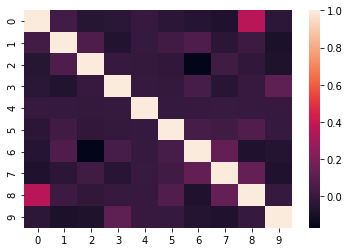

Key:
0 " It is my duty , and I am sure it is my wish ," she continued , " to have no reserves with you on this subject .
1 They arrived , the carriage turned , the step was let down , and Mr . Elton , spruce , black , and smiling , was with them instantly .
2 There was one person among his new acquaintance in Surry , not so leniently disposed .
3 Jane very patiently assured her that she had not caught any cold .
4 CHAPTER XVI
5 " It might be distressing , for the moment ," said she ; " but you seem to have behaved extremely well ; and it is over  and may never  can never , as a first meeting , occur again , and therefore you need not think about it ."
6 " Very well ; and if he had intended to give her one , he would have told her so ."
7 " She must have some motive , more powerful than appears , for refusing this invitation ," was Emma ' s conclusion .
8 " And I have not forgotten ," said Emma , " how sure you were that he might have come sooner if he would .
9 " Leave it to me .


In [22]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

Not much similarity between the sentences except for some similarity between sentences 0 and 8.


## Drill 0: